In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Importing day-wise data of cities
cities = pd.read_csv('city_day.csv')
cities.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,1/1/2015,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,0.0,NaN
1,Ahmedabad,1/2/2015,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,0.0,NaN
2,Ahmedabad,1/3/2015,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,0.0,NaN
3,Ahmedabad,1/4/2015,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,0.0,NaN
4,Ahmedabad,1/5/2015,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,0.0,NaN


# Step 2: Train the Linear Regression model and evaluate its performance


In [11]:
# Data preprocessing
cities['Date'] = pd.to_datetime(cities['Date'])
cities.fillna(0, inplace=True)

# Step 2: Train the Linear Regression model and evaluate its performance
# Preparing the dataset for linear regression
predictors = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
X = cities[predictors]
y = cities['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 3809.790554827331
R2 Score: 0.7975153458062607


In [12]:
# Filter out rows with zero AQI
valid_test_mask = y_test != 0
valid_y_test = y_test[valid_test_mask]
valid_y_pred = y_pred[valid_test_mask]

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((valid_y_test - valid_y_pred) / valid_y_test)) * 100
accuracy = 100 - mape

print("Prediction Accuracy Percentage:", accuracy)


Prediction Accuracy Percentage: 78.79776213730918


# Step 3: Implement Ridge regression for hyperparameter tuning and Calculate  	 the Prediction Accuracy Percentage for both models



In [15]:

# Define the hyperparameters and their possible values
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Create the Ridge regression model
ridge = Ridge()

# Perform GridSearchCV to find the best hyperparameters
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)

# Train and predict using the best hyperparameters
best_ridge = Ridge(alpha=ridge_regressor.best_params_['alpha'])
best_ridge.fit(X_train, y_train)
best_y_pred = best_ridge.predict(X_test)

# Filter out rows with zero AQI for the tuned model
valid_best_y_pred = best_y_pred[valid_test_mask]


# Calculate the mean absolute percentage error (MAPE) for the tuned model
mape_tuned = np.mean(np.abs((valid_y_test - valid_best_y_pred) / valid_y_test))
accuracy_tuned = 100 - mape_tuned

print("Tuned Prediction Accuracy Percentage:", accuracy_tuned)

Tuned Prediction Accuracy Percentage: 99.78797681766756


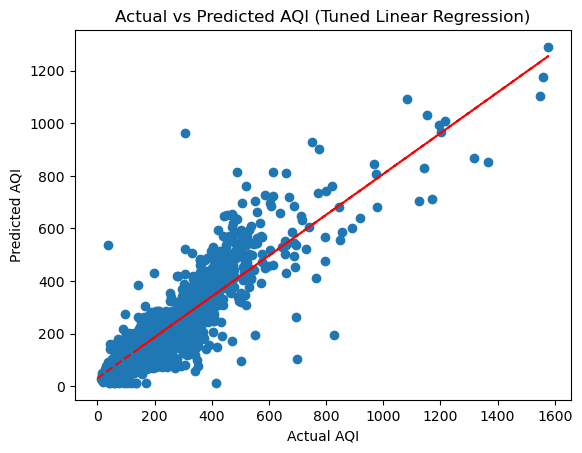

In [20]:
# Visualization of the model's predictions vs actual values
plt.scatter(valid_y_test, valid_best_y_pred)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI (Tuned Linear Regression)")
# Adding a fitting line
z = np.polyfit(y_test, best_y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "r--")
plt.show()


In [21]:
# Feature importances (coefficients)
importance = pd.DataFrame({'Feature': predictors, 'Importance': model.coef_})
importance.sort_values('Importance', ascending=False, inplace=True)
print(importance)

    Feature  Importance
6        CO   10.198006
0     PM2.5    1.089777
7       SO2    0.723274
3       NO2    0.446488
8        O3    0.334266
10  Toluene    0.206997
11   Xylene    0.184974
1      PM10    0.162796
2        NO    0.044968
4       NOx    0.026075
5       NH3   -0.017971
9   Benzene   -0.257390


From the coefficients (importance) of the model, we can draw some insights about the impact of each pollutant on AQI:

1) CO (Carbon Monoxide) has the highest importance with a positive coefficient of 10.198, indicating that an increase in CO concentration leads to a significant increase in AQI.

2) PM2.5 (Fine Particulate Matter) has the second-highest importance with a positive coefficient of 1.0898, suggesting that an increase in PM2.5 concentration also contributes to an increase in AQI, but with a lesser impact than CO.

3) Benzene has a negative coefficient of -0.2574, implying that an increase in Benzene concentration may lead to a slight decrease in AQI. However, this should be taken with caution, as the relationship between Benzene and AQI is not straightforward, and it might be influenced by other factors.

4) Other pollutants, like SO2, NO2, O3, Toluene, Xylene, PM10, NO, NOx, and NH3, also impact AQI but to a lesser extent than CO and PM2.5.